# SIR Model on Traffic and its Application

## Table of Contents
TODO: Clean up the notebook
- [Simple SIR Model (Saberi)](#Simple-SIR-Model-(Saberi))
- [Simple SIR Model (Froese)](#Simple-SIR-Model-(Froese))

# Simple SIR Model (Saberi)

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# ipywidgets currently only works with jupyter notebook, not lab
# installation guide: https://ipywidgets.readthedocs.io/en/stable/user_install.html
import ipywidgets as widgets
from ipywidgets import HBox, VBox, interactive
from IPython.display import display
%matplotlib inline

In [2]:
def plot_simple_SIR(beta=0.2, gamma=0.1):
    # Total population, N.
    N = 1000
    # Initial number of infected and recovered individuals, I0 and R0.
    I0, R0 = 1, 0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    # beta, gamma = 0.2, 1./10 
    # A grid of time points (in days)
    t = np.linspace(0, 160, 160)

    # The SIR model differential equations.
    def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

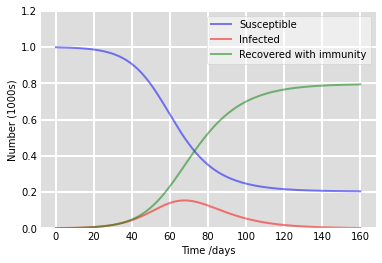

interactive(children=(FloatSlider(value=0.2, description='beta', max=1.0, step=0.01), FloatSlider(value=0.1, d…

In [3]:
# Interactive beta and gamma
# beta: effective contact rate
# gamma: mean recovery rate, where 1/γ is 
#        the mean period of time during which 
#        an infected individual can pass it on

interactive_plot = interactive(plot_simple_SIR, beta=(0.0, 1.0, 0.01), gamma=(0.0, 1.0, 0.01))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

In [4]:
def plot_fremont_SIR(beta=0.25, gamma=0.05):
    # Total population, N.
    N = 4397
    # Initial number of infected and recovered individuals, I0 and R0.
    # rho = 0.9
    I0, R0 = 450, 0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    # beta, gamma = 0.2, 1./10 
    # A grid of time points (in quarters of an hour)
    t = np.linspace(0, 24, 24)

    # The SIR model differential equations.
    def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
#     ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

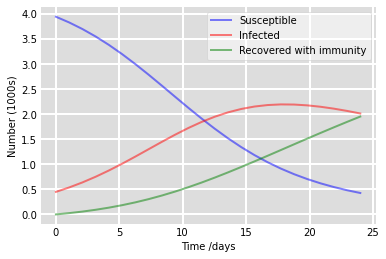

interactive(children=(FloatSlider(value=0.25, description='beta', max=1.0, step=0.01), FloatSlider(value=0.05,…

In [5]:
# Interactive beta and gamma
# beta: effective contact rate
# gamma: mean recovery rate, where 1/γ is 
#        the mean period of time during which 
#        an infected individual can pass it on

interactive_plot = interactive(plot_fremont_SIR, beta=(0.0, 1.0, 0.01), gamma=(0.0, 1.0, 0.01))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

## Building the Traffic SIR Model (Saberi, M. et al.)

In [8]:
def congested(v_t, v_max, rho):
    """
    Return whether the link is congested
    
    Parameters:
        v_t: the speed of the link at time t
        v_max: the speed limit of the link
        rho (float): congestion threshold
        
    Returns:
        congested (int): 1 if congested else 0
    """
    congested = (v_t / v_max) < rho
    return congested

In [9]:
def propagation_time(l, q_c, v_f, k_j):
    """
    Return the time for congestion to propagate from link i
    to the upstream link (i + 1)
    
    Parameters:
        l: the length of the link
        q_c: maximum flow of the link
        v_f : free fkiw speed
        k_j: jam density
        
    Returns:
        eta (float): propagation time
    """
    # critical density
    k_c = q_c / v_f
    
    # shockwave speed
    omega = q_c / (k_j - k_c)
    
    # propagation time
    eta = l / omega
    
    return eta

In [10]:
def deriv_congested_links(l, q, v_f, k_j, t):
    eta = propagation_time(l, q[t], v_f, k_j)
    dCdt = 1 / eta
    return dCdt

In [13]:
def plot_traffic_SIR(beta=0.2, miu=0.1):
    # Number of directed links
    N = 1000
    # Initial number of congested links
    C_0 = 100
    # Initial number of recovered links
    R_0 = 0
    # Initial number of free flow links
    F_0 = N - C_0 - R_0
    # average effective contacts at upstream,
    # derived from homogenous mixing assumption
    k = 1 # needs adjacency matrix
    
    c_0, r_0, f_0 = C_0 / N, R_0 / N, F_0 / N

    # A grid of time points (in 360 mins)
    t = np.linspace(0, 360, 360)

    # The SIR model differential equations
    def deriv_traffic(y, t, N, beta, miu):
        """
        Return the ordinary differential equations (ODEs) at time t

        Parameters:
            y: the initial conditions [F, C, R]
            t: time steps
            N: total number of links
            beta: congestion propagation rate
            miu: congestion recovery rate

        Returns:
            the ODEs at time t
        """
        f, c, r = y

        dcdt = - miu * c + beta * k * c * (1 - r - c)
        drdt = miu * c
        dfdt = - beta * k * c * (1 - r - c)

        return dcdt, drdt, dfdt

    # Initial conditions vector
    y_0 = f_0, c_0, r_0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv_traffic, y_0, t, args=(N, beta, miu))
    F, C, R = ret.T

    # Plot the data on three separate curves for F(t), C(t) and R(t)
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.plot(t, F/N, 'b', alpha=0.5, lw=2, label='Freeflow')
    ax.plot(t, C/N, 'r', alpha=0.5, lw=2, label='Congested')
    ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered')
    ax.set_xlabel('Time /mins')
    ax.set_ylabel('Number (1000s)')
    ax.set_ylim(0, 1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

In [14]:
# Interactive beta and gamma
# beta: effective contact rate
# gamma: mean recovery rate, where 1/γ is 
#        the mean period of time during which 
#        an infected individual can pass it on

interactive_plot = interactive(plot_traffic_SIR, beta=(0.0, 1.0, 0.01), miu=(0.0, 1.0, 0.01))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.2, description='beta', max=1.0, step=0.01), FloatSlider(value=0.1, d…

In [17]:
def plot_traffic_SIR(beta=0.2, miu=0.1):
    # Number of directed links
    N = 1000
    # Initial number of congested links
    C_0 = 1
    # Initial number of recovered links
    R_0 = 0
    # Initial number of free flow links
    F_0 = N - C_0 - R_0
    # average effective contacts at upstream,
    # derived from homogenous mixing assumption
    k = 1 # needs adjacency matrix

    # A grid of time points (in 360 mins)
    t = np.linspace(0, 360, 360)

    # The SIR model differential equations
    def deriv_traffic(y, t, N, beta, miu):
        """
        Return the ordinary differential equations (ODEs) at time t

        Parameters:
            y: the initial conditions [F, C, R]
            t: time steps
            N: total number of links
            beta: congestion propagation rate
            miu: congestion recovery rate

        Returns:
            the ODEs at time t
        """
        F, C, R = y
        frac_F, frac_C, frac_R = F / N, C / N, R / N

        dFdt = - beta * k * C * (1 - frac_R - frac_C)
        dCdt = - miu * C + beta * k * C * (1 - frac_R - frac_C)
        dRdt = miu * C
        
        return dCdt, dRdt, dFdt

    # Initial conditions vector
    y_0 = F_0, C_0, R_0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv_traffic, y_0, t, args=(N, beta, miu))
    F, C, R = ret.T

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.plot(t, F/N, 'b', alpha=0.5, lw=2, label='Freeflow')
    ax.plot(t, C/N, 'r', alpha=0.5, lw=2, label='Congested')
    ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered')
    ax.set_xlabel('Time /mins')
    ax.set_ylabel('Number (1000s)')
    ax.set_ylim(0, 1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

In [18]:
# Interactive beta and gamma
# beta: effective contact rate
# gamma: mean recovery rate, where 1/γ is 
#        the mean period of time during which 
#        an infected individual can pass it on

interactive_plot = interactive(plot_traffic_SIR, beta=(0.0, 1.0, 0.01), miu=(0.0, 1.0, 0.01))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.2, description='beta', max=1.0, step=0.01), FloatSlider(value=0.1, d…

## Extract data from the provided simulation (10/18)

In [11]:
import sqlite3
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as cx

In [18]:
# GLOBAL VARIABLES/CONSTANTS

# SQLite File Path formatter
__SQLITE_PATH_FORMAT = "Data/carl_10_18_18_saberi/Dynamel_06_09_2018_rpl_{number}.sqlite"

# sections.shp File Path
# __SECTION_SHP = "Data/sections.shp"

# Number of experiments
__NUM_EXP = 3

# SQL Query to be excecuted for MISECT table
__SQL_EXTRACT_QUERY = 'SELECT * FROM MESECT'

# Columns to extract from MISECT table
__COLUMNS = ['ent', 'eid', 'flow', 'count', 'flow_capacity', 'speed', 'travel', 'traveltime']

In [19]:
# Create a SQL connection to our SQLite database

# A list of established connections to our databases
con = []

for i in range(__NUM_EXP):
    con.append(sqlite3.connect(__SQLITE_PATH_FORMAT.format(number=i+1)))

In [ ]:
# Run SQL query and convert SQL to DataFrame

# List of the sql queries
sql_queries = []

# List of dataframes extracted from each experiment
df = []
for i in range(__NUM_EXP):
    # Run SQL
    query = pd.read_sql(__SQL_EXTRACT_QUERY, con[i])
    sql_queries.append(query)
    
    # Convert SQL to DataFrame
    dataframe = pd.DataFrame(query, columns = __COLUMNS)
    df.append(dataframe)

In [ ]:
# Create a deep copy of df as back up in order not to rerun the above cell
df_saberi_copy = copy.deepcopy(df)

# Simple SIR Model (Froese)

In [2]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

In [3]:
def rmse(pred, y):
    return np.sqrt(np.mean((pred - y) ** 2))

In [4]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [5]:
N = 1000
beta = 1.0  # infected person infects 1 other person per day
D = 4.0 # infections lasts four days
gamma = 1.0 / D

S0, I0, R0 = 999, 1, 0  # initial conditions: one infected, rest susceptible

In [6]:
t = np.linspace(0, 49, 50) # Grid of time points (in days)
y0 = S0, I0, R0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

In [7]:
def plotsir(t, S, I, R):
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')

    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

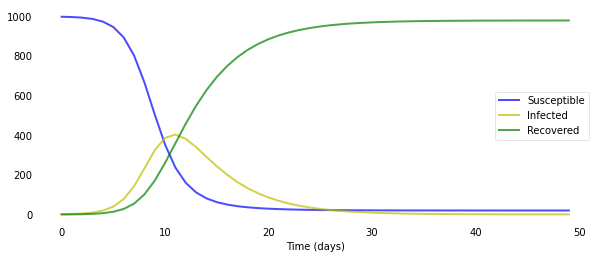

In [8]:
plotsir(t, S, I, R)

In [89]:
# GLOBAL VARIABLES/CONSTANTS

# SQLite File Path formatter
__SQLITE_PATH_FORMAT = "Data/alben_06_13_{number}0/micro_config.sqlite"

# sections.shp File Path
__SECTION_SHP = "Data/sections.shp"

# Number of experiments
__NUM_EXP = 11

# Output File Directory
__OUTPUT = "Output/"

# SQL Query to be excecuted for different tables
__SQL_EXTRACT_MISECT_QUERY = 'SELECT * FROM MISECT'
__SQL_EXTRACT_MILANE_QUERY = 'SELECT * FROM MILANE'

# Columns to extract from different tables
__MISECT_COLUMNS = ['ent', 'eid', 'flow_capacity', 'speed', 'travel', 'traveltime', 'density', 'flow']
__MILANE_COLUMNS = ['ent', 'eid', 'lane', 'flow', 'density', 'input_flow']

# Actual time for each time step
__TIME_REAL = ['14:15', '14:30', '14:45', '15:00', '15:15', '15:30', '15:45', '16:00', '16:15', '16:30', '16:45', '17:00', '17:15', '17:30', '17:45', '18:00', '18:15', '18:30', '18:45', '19:00', '19:15', '19:30', '19:45', '20:00']

In [90]:
# Create a SQL connection to our SQLite database

# A list of established connections to our databases
con = []

for i in range(__NUM_EXP):
    con.append(sqlite3.connect(__SQLITE_PATH_FORMAT.format(number=i)))

In [91]:
# Run SQL query and convert SQL to DataFrame

# List of dataframes extracted from each experiment
df = []
df_milane = []
for i in range(__NUM_EXP):
    # Run SQL
    query = pd.read_sql(__SQL_EXTRACT_MISECT_QUERY, con[i])
    
    # Convert SQL to DataFrame
    dataframe = pd.DataFrame(query, columns = __MISECT_COLUMNS)
    df.append(dataframe)
    
    query = pd.read_sql(__SQL_EXTRACT_MILANE_QUERY, con[i])
    dataframe = pd.DataFrame(query, columns = __MILANE_COLUMNS)
    df_milane.append(dataframe)

In [92]:
# Read the sections.shp shapefile
sections = gpd.read_file(__SECTION_SHP)
sections.crs

<Derived Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [93]:
# Create a deep copy of df as back up in order not to rerun the above cell
df_copy = copy.deepcopy(df)
df_milane_copy = copy.deepcopy(df_milane)
sections_copy = copy.deepcopy(sections)

In [104]:
# Restore the sections file in case of modification
sections = copy.deepcopy(sections_copy)
sections = sections.rename(columns={'speed': 'speed_limit'})
df = copy.deepcopy(df_copy)

In [105]:
total_length = sections['geometry'].length.sum()
total_length

393362.7850271843

In [106]:
total_num_sections = len(sections['eid'].unique())
total_num_sections

4397

In [107]:
for i in range(__NUM_EXP):
    df[i] = df[i][df[i]['speed'] >= 0.0]

In [108]:
df[0].shape

(167450, 8)

## Using Experiment 0 (0% SRC) for experiment, congestion threshold = 0.9

In [109]:
EXP_INDEX = 0

In [110]:
# Preprocess dataframe to merge with sections

group_cols = ['ent', 'eid']
# identify the columns which we want to average; this could
# equivalently be defined as list(df.columns[4:])
metric_cols = ['speed']

# create a new DataFrame with a MultiIndex consisting of the group_cols
# and a column for the mean of each column in metric_cols
aggs = []
for i in range(__NUM_EXP):
    aggs.append(df[i].groupby(group_cols)[metric_cols].mean())

# 1. remove the metric_cols from df because we are going to replace them
# with the means in aggs 
# 2. dedupe to leave only one row with each combination of group_cols
# in df
for i in range(__NUM_EXP):
    # Step 1
    df[i].drop(metric_cols, axis=1, inplace=True)
    
    # Step 2
    df[i].drop_duplicates(subset=group_cols, keep='last', inplace=True)

# add the mean columns from aggs into df
for i in range(__NUM_EXP):
    df[i] = df[i].merge(right=aggs[i], right_index=True, left_on=group_cols, how='right')

# Merge datasets: sections and dataframe
sections_cong = []

for i in range(__NUM_EXP):
    sections_cong.append(pd.merge(df[i], sections, how='left', left_on='eid', right_on='eid'))
    
for i in range(__NUM_EXP):
    sections_cong[i] = sections_cong[i][['ent', 'eid', 'speed', 'speed_limit', 'geometry']]

# Convert the merged sections into GeoDataFrame and drop null values
gdf = []

for i in range(__NUM_EXP):
    gdf.append(gpd.GeoDataFrame(sections_cong[i], geometry='geometry'))
    gdf[i]['speed'] = gdf[i]['speed'].dropna()
    gdf[i]['length'] = gdf[i]['geometry'].length

# Threshold for a section to be considered congested
rho = [0.9]

# Add a column for each section at each threshold,
# congested = 1, else 0
for threshold in rho:
    for i in range(__NUM_EXP):
        speed_ratio = gdf[i]['speed'] / gdf[i]['speed_limit']
        gdf[i]['congested at rho = ' + str(round(threshold, 1))] = [int(r < threshold) for r in speed_ratio]

# Add a column for congestion weight at each threshold,
# congested = 1, else 0
for threshold in rho:
    for i in range(__NUM_EXP):
        weight = gdf[i]['length'] * gdf[i]['congested at rho = ' + str(round(threshold, 1))]
        gdf[i]['weight at rho = ' + str(round(threshold, 1))] = weight
        
# Group each GeoDataFrame on timestep and aggregate by sum
# Remove the first row as it is the average of the rest
gdf_agg = []

for i in range(__NUM_EXP):
    gdf_agg.append(gdf[i].groupby('ent').agg(np.sum).iloc[1:, :])
    
for threshold in rho:
    for i in range(__NUM_EXP):
        gdf_agg[i]['congestion ratio at rho = ' + str(round(threshold, 1))] = gdf_agg[i]['weight at rho = ' + str(round(threshold, 1))] / total_length

In [111]:
gdf[0].head()

,ent,eid,speed,speed_limit,geometry,length,congested at rho = 0.9,weight at rho = 0.9
0,0,1006,42.602214,40.0,"LINESTRING (594915.528 4153115.726, 594923.056...",152.121445,0,0.0
1,0,1007,42.630965,40.0,"LINESTRING (594869.773 4152995.061, 594853.486...",111.162017,0,0.0
2,0,1008,41.919752,40.0,"LINESTRING (594881.704 4152991.218, 594890.202...",157.722161,0,0.0
3,0,1009,41.969505,40.0,"LINESTRING (594764.923 4152972.321, 594784.763...",109.475766,0,0.0
4,0,1017,39.965519,40.0,"LINESTRING (594110.032 4153261.929, 594094.708...",326.170565,0,0.0


In [112]:
gdf[0].groupby('ent').size()

ent
0     3469
1     2150
2     2523
3     2484
4     2580
5     2624
6     2639
7     2704
8     2773
9     2722
10    2686
11    2724
12    2738
13    2779
14    2859
15    2845
16    2810
17    2807
18    2849
19    2781
20    2768
21    2737
22    2723
23    2655
24    2663
dtype: int64

In [113]:
gdf_agg[0]['congested at rho = 0.9'].tolist()

[450,
 550,
 528,
 549,
 558,
 576,
 597,
 629,
 589,
 594,
 595,
 592,
 643,
 643,
 638,
 653,
 653,
 637,
 636,
 656,
 659,
 618,
 592,
 578]

In [71]:
def plotsir_w_real_data(t, S, I, R, y_real):
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax.scatter(t, y_real, color='r', alpha=0.7)

    ax.set_xlabel('Time (experiment step)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()
    print(f"Root mean square error: {str(rmse(I, y_real))}")

3.108797882295539


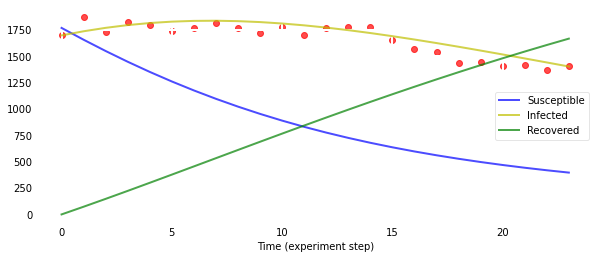

Root mean square error: 75.27131680156201


In [77]:
N = 3469 # total population using data from ent[0]
beta = 0.13210732374258966 # congested road section infects 1 other road section per timestep
gamma = 0.04249466473678935 # Recovery rate
D = 1 / gamma
print(beta / gamma)

# initial conditions: I0 congested, rest susceptible
I0 = gdf_agg[0]['congested at rho = 0.9'].tolist()[0]
S0, R0 = N - I0, 0

t = np.linspace(0, 23, 24) # Grid of time points (in timesteps)
y0 = S0, I0, R0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

plotsir_w_real_data(t, S, I, R, gdf_agg[0]['congested at rho = 0.9'].tolist())

# General Pipeline for Fitting an SIR Model to an Experiment

In [ ]:
# from <module> import <calculation function>

In [ ]:
def SIR_per_experiment(experiment_number, gdf, gdf_agg):
    N = gdf[experiment_number].groupby('ent').size().tolist()[0] # total population using data from ent[0]
    paramests_fit = <func>
    beta, gamma = paramests_fit
    D = 1 / gamma
    print("$R_0 = $" + str(beta / gamma))

    # initial conditions: I0 congested, rest susceptible
    I0 = gdf_agg[experiment_number]['congested at rho = 0.9'].tolist()[0]
    S0, R0 = N - I0, 0

    t = np.linspace(0, 23, 24) # Grid of time points (in timesteps)
    y0 = S0, I0, R0 # Initial conditions vector

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T

    plotsir_w_real_data(t, S, I, R, gdf_agg[0]['congested at rho = 0.9'].tolist())